# **Como Vacinar os Vértices de Uma Rede**
## **Projeto Final - Processos Dinâmicos em Redes Complexas**


**Aluno: Nathan Augusto Rufino**

**NUSP: 17076128**

## Introdução

O objetivo deste trabalho é verificar, por meio de redes sociais, qual a melhor métrica de centralidade para a vacinação dos vértices de uma rede. Para isso, utilizou-se o modelo de simulação SIR (Susceptible-Infected-Recovered) para simular a propagação da epidemia nas redes analisadas. Além disso, no final é realizada uma análise para verificar se valores altos em métricas estruturais específicas aumentam a facilidade de propagação da epidemia.

As métricas de centralidade analisadas foram:
* Degree  
* Betweenness  
* Closeness  
* Eigenvector  
* K-core

### Redes Utilizadas

Todas as redes utilizadas foram obtidas no seguinte link: https://icon.colorado.edu/

No total foram selecionadas 8 redes, visando variar o tamanho e contexto das redes para uma análise mais robusta, sendo essas as seguintes:



* Amazon Mechanical Turkers (2016) → Rede entre trabalhadores da Amazon Mechanical Turk que podiam se comunicar online.

* DNC emails (2016) → Rede de trocas de e-mails entre membros do Comitê Nacional Democrata.

* Douban friendship network (2009) → Rede de amizade entre usuários da plataforma Douban (China).

* Jazz collaboration network → Rede de colaboração entre músicos e bandas de jazz.

* New Guinea Highlands tribes (1954) → Rede de relações entre tribos da aliança Gahuku-Gama.

* Scientific collaborations in network science (2006) → Rede de coautoria entre pesquisadores da área de ciência de redes.

* Zachary Karate Club → Rede de amizades entre membros de um clube de caratê universitário.

* Madrid train bombing terrorists (2004) → Rede de contatos entre suspeitos do atentado em Madri 2004.

In [12]:
!pip install -q EoN networkit

In [13]:
import EoN
import numpy as np
import networkx as nx
import networkit as nk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from urllib.parse import quote
from scipy.stats import pearsonr

As redes estão salvas em um repositório público no GitHub: https://github.com/nathanruf/Vacinacao-em-Redes-Complexas.


Vou importar as redes e realizar a leitura, os pesos das redes foram ignorados.

In [14]:
files = [
  'Amazon Mechanical Turkers (2016).csv',
  'DNC emails (2016).txt',
  'Douban friendship network (2009).txt',
  'Jazz collaboration network.txt',
  'Madrid train bombing terrorists (2004).txt',
  'New Guinea Highlands tribes (1954).txt',
  'Scientific collaborations in network science (2006).gml',
  'Zachary Karate Club.gml'
]

nets = []

base_url = 'https://raw.githubusercontent.com/nathanruf/Vacinacao-em-Redes-Complexas/main/data/'

for filename in files:
  url = base_url + quote(filename)
  with urlopen(url) as f:
    if 'gml' in filename:
      G = nx.Graph()
      G.add_edges_from(nx.read_gml(f).edges()) #removes edge weights
      nets.append(G)
    elif 'csv' in filename:
      df = pd.read_csv(url)
      nets.append(nx.from_pandas_edgelist(df, source='From', target='To'))
    else:
      nets.append(nx.read_edgelist(f, data=False, comments='%'))

In [15]:
for f, net in zip(files, nets):
  print(f)
  print(f'{net}\n')

Amazon Mechanical Turkers (2016).csv
Graph with 1389 nodes and 5268 edges

DNC emails (2016).txt
Graph with 906 nodes and 10429 edges

Douban friendship network (2009).txt
Graph with 154908 nodes and 327162 edges

Jazz collaboration network.txt
Graph with 198 nodes and 2742 edges

Madrid train bombing terrorists (2004).txt
Graph with 64 nodes and 243 edges

New Guinea Highlands tribes (1954).txt
Graph with 16 nodes and 58 edges

Scientific collaborations in network science (2006).gml
Graph with 1461 nodes and 2742 edges

Zachary Karate Club.gml
Graph with 34 nodes and 78 edges



Foi considerado apenas o maior componente da rede, com o objetivo de evitar erros em algumas métricas que dependem da conectividade do grafo

In [16]:
for i, net in enumerate(nets):
  G = max(nx.connected_components(net), key=len)
  nets[i] = net.subgraph(G).copy()

## Definição das Funções e Parâmetros de Simulação

Função que recebe uma rede e um valor de beta (taxa de infecção) para realizar a simulação usando o modelo SIR. O valor de mu (taxa de recuperação) foi fixado em 0,5, a fração inicial de infectados em 5% e o Ns (número de simulações) em 50.

In [17]:
def simulate_SIR(beta, G, mu=0.5, Ns=50, initial_infecteds_frac=0.05):
  N = G.number_of_nodes()
  initial_infecteds = list(np.random.choice(
  G.nodes(),
    size=max(1, int(initial_infecteds_frac * N)),  #at least 1 infected
    replace=False
  ))

  final_Rs = []

  for _ in range(Ns):
    t, S, I, R = EoN.fast_SIR(G, beta, mu, initial_infecteds=initial_infecteds)
    final_R = R[-1] / N  #final fraction of recovered
    final_Rs.append(final_R)

  final_Rs_mean = np.mean(final_Rs)
  return final_Rs_mean

A seguinte função recebe uma lista de redes, uma métrica de centralidade e os parâmetros de simulação: betas (taxas de infecção), vaccinated_fractions (frações de vértices vacinados), mu (taxa de recuperação), Ns (número de simulações) e initial_infecteds_frac (fração inicial de infectados). Para cada rede, ela remove os vértices mais centrais baseado na métrica passada e chama a função simulate_SIR para calcular a propagação da epidemia após a vacinação.

In [18]:
def simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metric, mu=0.5, Ns=50, initial_infecteds_frac=0.05):
  results_list = []
  for G in nets:
    N = G.number_of_nodes()
    R_matrix = np.zeros((len(vaccinated_fractions), len(betas)))

    metric_values = dict(vaccination_metric(G))
    sorted_nodes = sorted(metric_values.items(), key=lambda x: x[1], reverse=True)

    for i, p in enumerate(vaccinated_fractions):
      num_vaccinated = int(p * N)
      vaccinated = [n for n, _ in sorted_nodes[:num_vaccinated]]

      vaccinated_graph = G.copy()
      vaccinated_graph.remove_nodes_from(vaccinated)

      for j, beta in enumerate(betas):
        R_mean = simulate_SIR(beta, vaccinated_graph, mu=mu, Ns=Ns, initial_infecteds_frac=initial_infecteds_frac)
        R_matrix[i, j] = R_mean

    results_list.append(R_matrix)

  return results_list

Função para gerar um heatmap com os resultados da função acima. O eixo x contém os valores de beta, o eixo y representa a porcentagem de vértices vacinados, e a intensidade da cor indica a porcentagem da população que foi infectada na epidemia.

In [28]:
def plot_heatmaps_grid(betas, vaccinated_fractions, results_R_list, network_names, ncols=4):
  n = len(network_names)
  nrows = int(np.ceil(n / ncols))

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))

  axes = axes.flatten()

  for idx, (R_matrix, name) in enumerate(zip(results_R_list, network_names)):
    sns.heatmap(R_matrix,
                xticklabels=5,
                yticklabels=[f'{p*100:.0f}%' for p in vaccinated_fractions],
                cmap='YlOrRd', annot=False, fmt=".2f",
                cbar=True,
                cbar_kws={"label": "Total Infected (%)"},
                ax=axes[idx])

    axes[idx].invert_yaxis()
    axes[idx].set_title(name, fontsize=10)
    axes[idx].set_xlabel("Beta")
    axes[idx].set_ylabel("% Vaccinated")

    axes[idx].set_xticks(np.linspace(0, len(betas) - 1, 6))  # 6 ticks
    axes[idx].set_xticklabels([f"{x:.2f}" for x in np.linspace(0, 1, 6)])

  #remove empty plots if there are fewer networks than grid positions
  for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

Funções para converter uma rede do NetworkX para o NetworKit e calcular a centralidade de closeness usando o NetworKit. Essa abordagem foi necessária devido à alta demora no cálculo de closeness com o NetworkX para redes grandes.

In [20]:
def nx_to_nk(G_nx):
  G_nk = nk.graph.Graph(n=len(G_nx.nodes()), weighted=False, directed=False)
  mapping = {node: i for i, node in enumerate(G_nx.nodes())}
  for u, v in G_nx.edges():
    G_nk.addEdge(mapping[u], mapping[v])
  return G_nk, mapping

In [21]:
def nk_closeness(G_nx):
  G_nk, mapping = nx_to_nk(G_nx)
  centrality = nk.centrality.Closeness(G_nk, True, False)
  centrality.run()
  scores = centrality.scores()
  reverse_mapping = {v: k for k, v in mapping.items()}
  return {reverse_mapping[i]: s for i, s in enumerate(scores)}

Definição dos valores de beta, frações de vacinados e das métricas de vacinação. A métrica betweenness foi calculada por meio de uma aproximação utilizando o parâmetro k, devido à alta demora no cálculo exato em redes grandes, sendo inviável para a maior rede utilizada.

In [22]:
betas = np.linspace(0.01, 1.0, 20)
vaccinated_fractions = [0.0, 0.05, 0.10, 0.15, 0.20]
vaccination_metrics = [nx.degree, lambda G: nx.betweenness(G, k=1000), nk_closeness,
                       lambda G: nx.eigenvector_centrality(G, max_iter=10000),
                       nx.core_number]
nets_names = [name.split('.')[0] for name in files]

## Simulações e Análises

### Heatmaps

Nessa seção, estão os heatmaps resultantes das simulações. Para cada uma das cinco métricas de vacinação utilizadas, foi gerado um gráfico para cada rede.

#### Vacinação pelo Grau

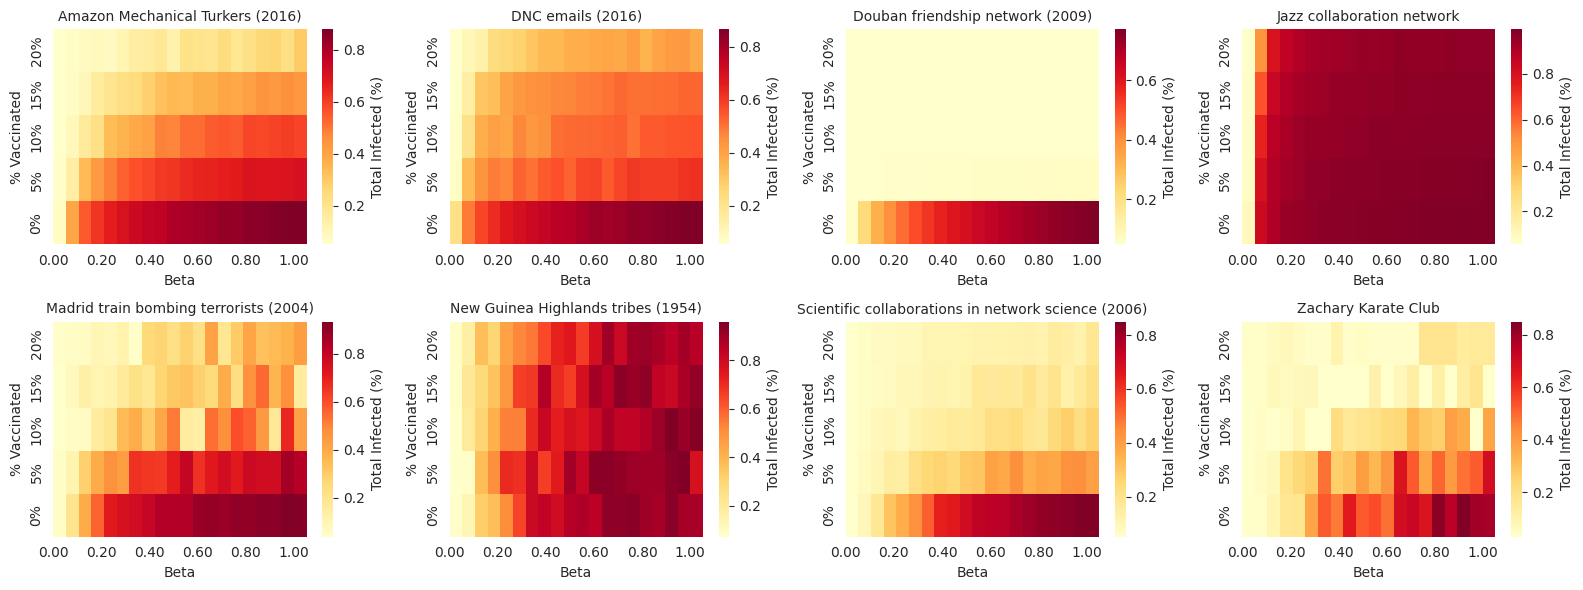

In [31]:
degree_results = simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metrics[0])
plot_heatmaps_grid(betas, vaccinated_fractions, degree_results, nets_names)

#### Vacinação pelo Betweenness

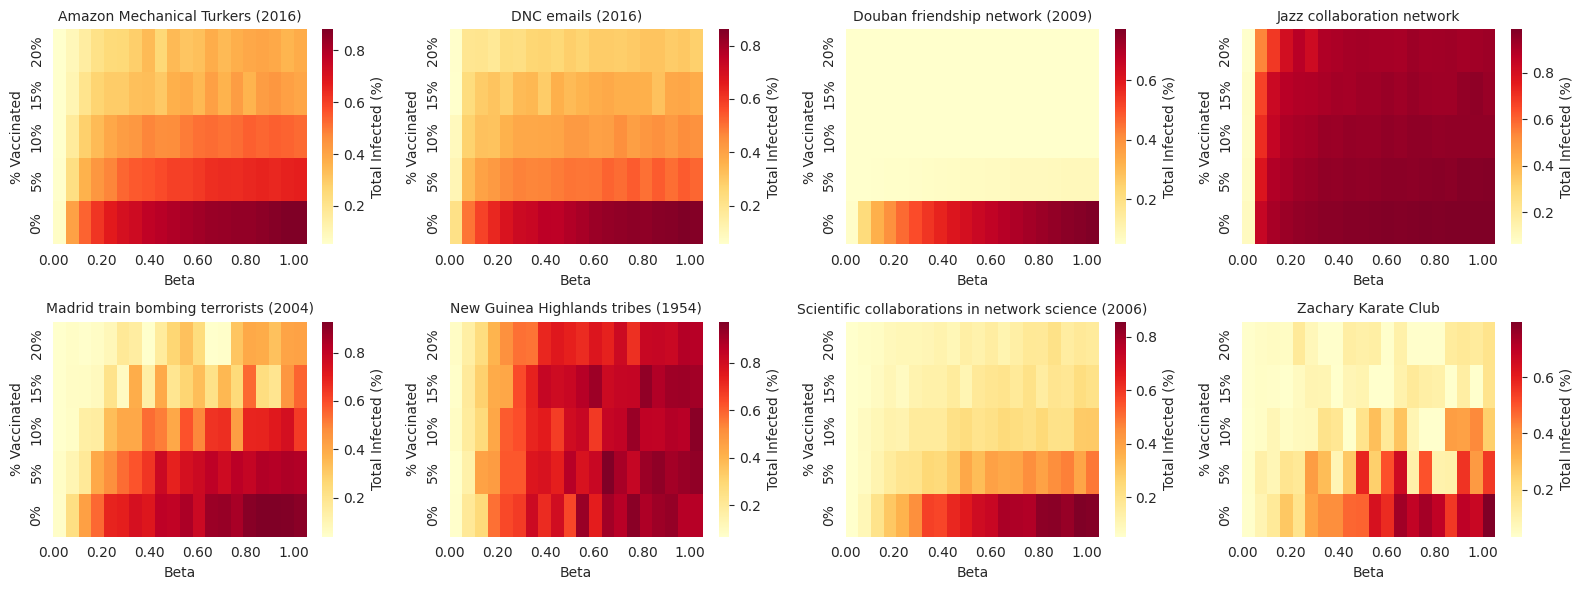

In [32]:
betweenness_results = simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metrics[1])
plot_heatmaps_grid(betas, vaccinated_fractions, betweenness_results, nets_names)

#### Vacinação pelo Closeness

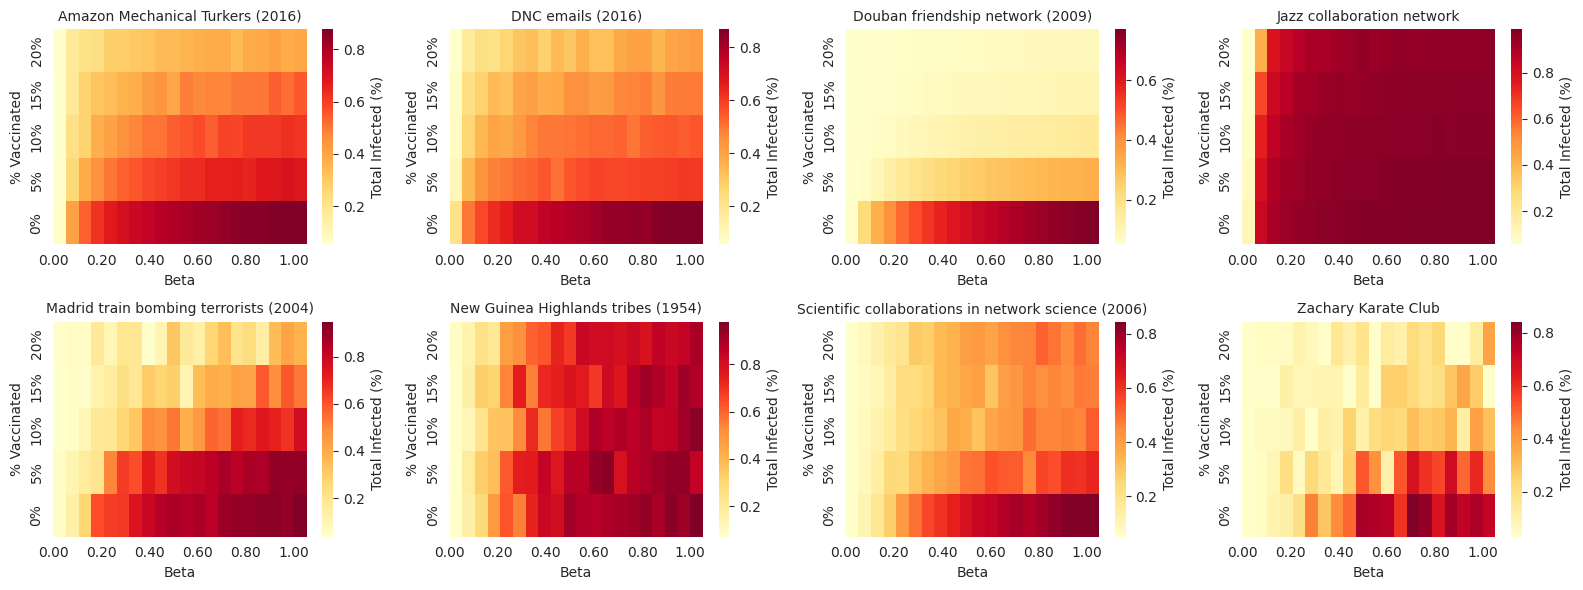

In [33]:
closeness_results = simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metrics[2])
plot_heatmaps_grid(betas, vaccinated_fractions, closeness_results, nets_names)

#### Vacinação pelo Eigenvector

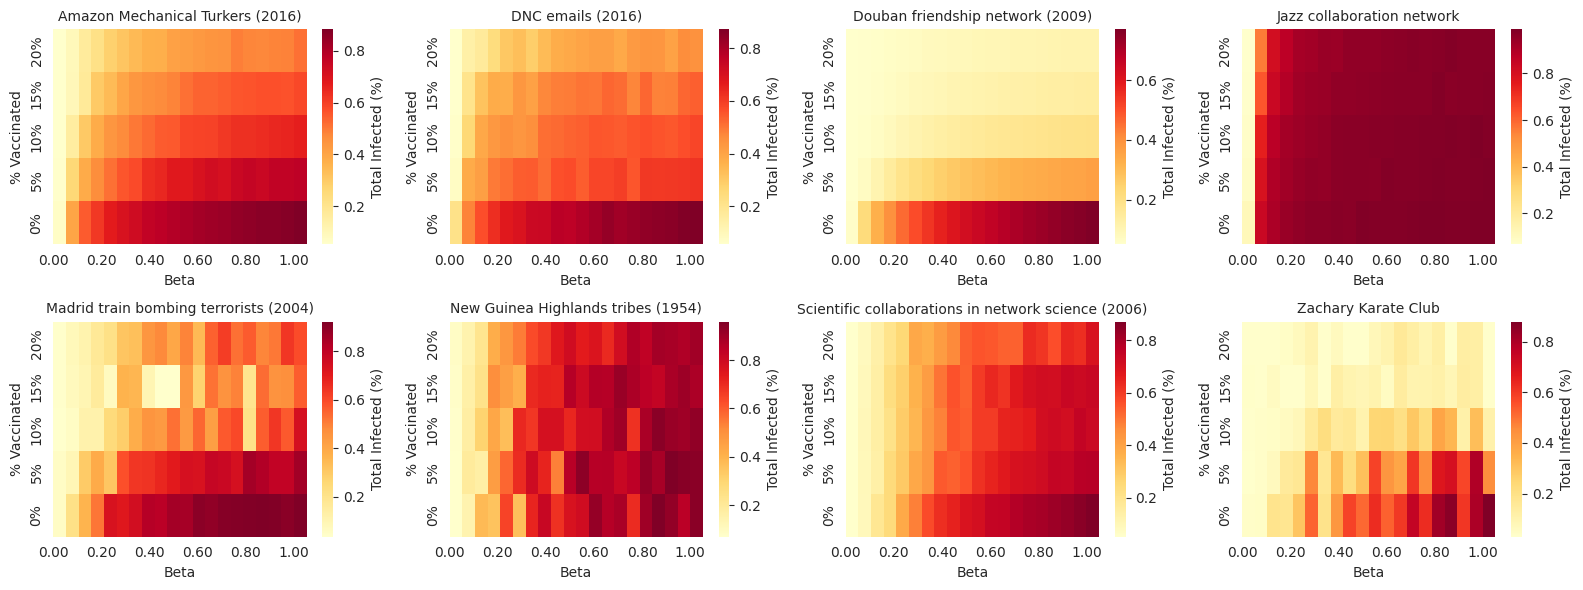

In [34]:
eigenvector_results = simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metrics[3])
plot_heatmaps_grid(betas, vaccinated_fractions, eigenvector_results, nets_names)

#### Vacinação pelo K-Core

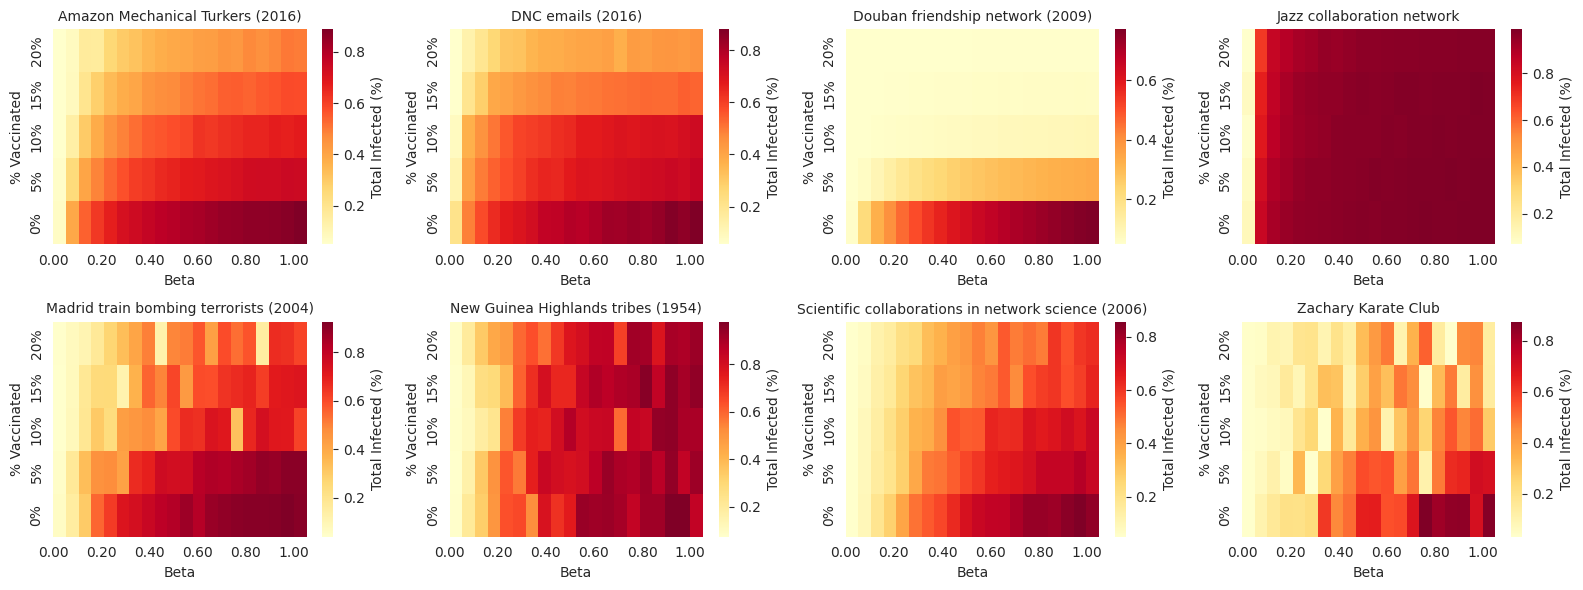

In [36]:
k_core_results = simulate_vaccination_by_metric(nets, betas, vaccinated_fractions, vaccination_metrics[4])
plot_heatmaps_grid(betas, vaccinated_fractions, k_core_results, nets_names)

### Boxplot Com Resultados

Para facilitar a comparação visual das métricas, foi criado um boxplot considerando o maior valor de beta (1), que representa o cenário mais grave da epidemia. Foi gerado um gráfico para cada porcentagem de vacinados. No eixo x estão as métricas de vacinação e, no eixo y, o total de infectados.

In [43]:
results_dict = {'Degree': degree_results,
                'Betweenness': betweenness_results,
                'Closeness': closeness_results,
                'Eigenvector': eigenvector_results,
                'K_core': k_core_results
                }

In [51]:
def plot_boxplots_by_vaccinated_fraction(results_dict, betas, vaccinated_fractions):
  sns.set_style("whitegrid")

  #remove 0% vaccinated
  vaccinated_fractions_filtered = [vf for vf in vaccinated_fractions if vf > 0]

  #highest beta
  beta_index = len(betas) - 1

  data = []
  for metric_name, results in results_dict.items():
    for matrix in results:
      for i, vaccinated_frac in enumerate(vaccinated_fractions_filtered):
        infected_frac = matrix[i+1, beta_index]  #+1 to skip 0%
        data.append({"Metric": metric_name,
                    "Vaccinated Fraction": vaccinated_frac,
                    "Total Infected (%)": infected_frac
                })

  df = pd.DataFrame(data)
  metric_order = sorted(df["Metric"].unique())

  num_plots = len(vaccinated_fractions_filtered)
  ncols = 2
  nrows = (num_plots + 1) // 2

  fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows), sharey=True)
  axes = axes.flatten()

  for idx, vaccinated_frac in enumerate(vaccinated_fractions_filtered):
    ax = axes[idx]
    subset = df[df["Vaccinated Fraction"] == vaccinated_frac]
    if subset.empty:
      ax.set_visible(False)
      continue

    sns.boxplot(
        data=subset,
        x="Metric",
        y="Total Infected (%)",
        hue="Metric",
        palette="Blues",
        legend=False,
        order=metric_order,
        ax=ax
    )

    ax.set_title(f"Vaccinated: {vaccinated_frac*100:.0f}%", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Total Infected (%)", fontsize=10)
    ax.tick_params(axis='x', rotation=20)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(2)

  #remove unused axes
  for j in range(len(vaccinated_fractions_filtered), len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  fig.subplots_adjust(hspace=0.3, wspace=0.1)
  plt.show()


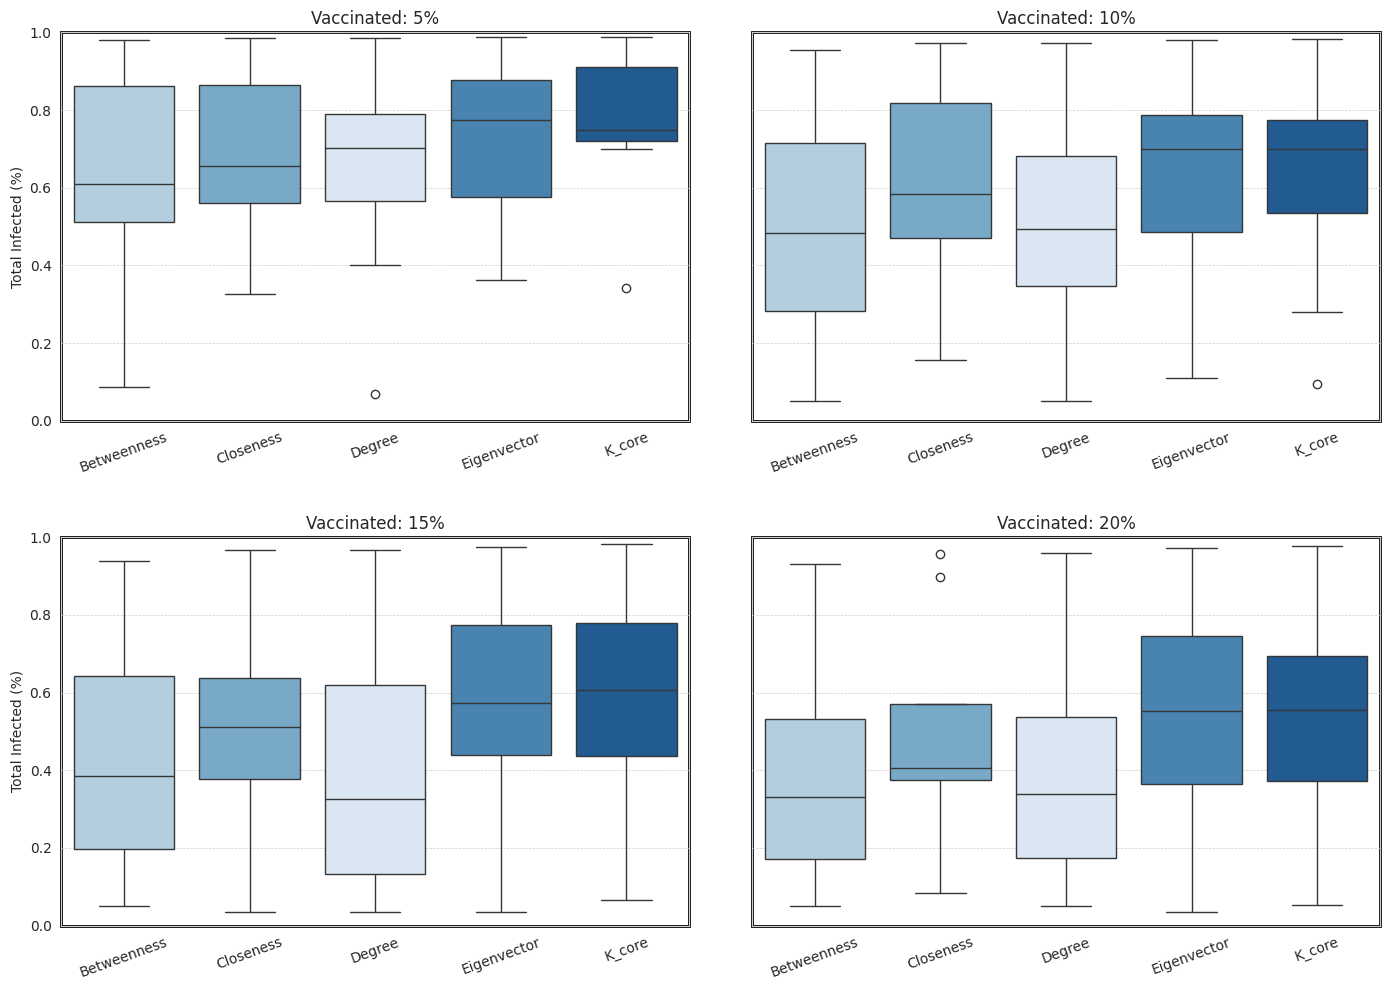

In [52]:
plot_boxplots_by_vaccinated_fraction(results_dict, betas, vaccinated_fractions)

As métricas de Degree e Betweenness parecem apresentar resultados superiores as demais métricas, pois seu total de infectados é em média menor que as demais métricas.

### Correlação Com Métricas Estruturais

Esta seção tem como objetivo analisar a existência de correlações entre a porcentagem final de infectados e certas métricas estruturais das redes.

In [ ]:
def compute_structure_correlation(results_dict, betas, vaccinated_fractions, networks, structure_metric_func):
  #highest beta and highest vaccination %
  beta_index = len(betas) - 1
  vaccinated_index = len(vaccinated_fractions) - 1

  structure_values = [structure_metric_func(G) for G in networks]

  correlations = []

  for metric_name, results in results_dict.items():
    recovered_fractions = [matrix[vaccinated_index, beta_index] for matrix in results]

    corr, p_value = pearsonr(structure_values, recovered_fractions)

    correlations.append({
        "Vaccination Metric": metric_name,
        "Pearson r": corr,
        "p-value": p_value
        })

  return pd.DataFrame(correlations)

#### Número de Nós

In [ ]:
compute_structure_correlation(results_dict, betas, vaccinated_fractions, nets, nx.number_of_nodes)

,Vaccination Metric,Pearson r,p-value
0,Degree,-0.447801,0.265866
1,Betweenness,-0.445320,0.268847
2,Closeness,-0.573276,0.137393
3,Eigenvector,-0.508982,0.197672
4,K_core,-0.589421,0.124126


#### Densidade

In [ ]:
compute_structure_correlation(results_dict, betas, vaccinated_fractions, nets, nx.density)

,Vaccination Metric,Pearson r,p-value
0,Degree,0.677439,0.064915
1,Betweenness,0.705421,0.050619
2,Closeness,0.689997,0.058237
3,Eigenvector,0.466686,0.243715
4,K_core,0.556584,0.151902


#### Clustering Médio

In [ ]:
compute_structure_correlation(results_dict, betas, vaccinated_fractions, nets, nx.average_clustering)

,Vaccination Metric,Pearson r,p-value
0,Degree,0.389791,0.339798
1,Betweenness,0.357679,0.384356
2,Closeness,0.553985,0.154233
3,Eigenvector,0.546061,0.161461
4,K_core,0.599840,0.115963


#### Assortatividade

In [ ]:
compute_structure_correlation(results_dict, betas, vaccinated_fractions, nets, nx.degree_assortativity_coefficient)

,Vaccination Metric,Pearson r,p-value
0,Degree,0.665615,0.071598
1,Betweenness,0.644788,0.084318
2,Closeness,0.530232,0.176439
3,Eigenvector,0.857339,0.006504
4,K_core,0.804656,0.016012


Entre as métricas estruturais analisadas, a assortatividade foi a que apresentou correlação mais clara com a propagação: redes com maior assortatividade tendem a ter um maior total de infectados. A densidade também sugeriu uma possível tendência, mas sem significância estatística clara. As demais métricas não mostraram relação consistente com os resultados.

## Conclusão

Os resultados indicam que as estratégias de vacinação baseadas nas métricas de Degree e Betweenness foram, em geral, as mais eficazes na contenção da epidemia. Além disso, observou-se uma correlação positiva entre a assortatividade das redes e a propagação da epidemia, sugerindo que redes mais assortativas tendem a facilitar o contágio.